In [1]:
%precision 3
import numpy as np
import pandas as pd
from IPython import display
from pathlib import Path
from sklearn import preprocessing, decomposition
from matplotlib import pyplot as plt, ticker, lines, patches
plt.style.use("minimal")

In [2]:
METADATA_LINES      = 9                     # number of lines to skip in logfile
SPATIAL_SCALE       = 1000                  # spatial measurements were recorded in millimeters
SAMPLE_RATE         = 300                   # Hz (samples/second)
DISPATCH_MARGIN     = 0.4                   # number of seconds before dispatch to consider in analysis
CUP_RADIUS          = 4.6                   # radius of cup in cm
BALL_RADIUS         = 0.95                  # radius of ball marker
CENTROID_OFFSET     = 2.5                   # offset from plane of cup centroid to cup brim plane
DATA_PATH           = Path("../Data")       # path to measurement directories
SHOWCASE_PATH       = Path("../Showcase")   # path to showcase export directory
SELECTED_MARKERS    = ["Ball", "CupCentroid", "Belt", "Neck", "ShoulderDominant", "Elbow", "Wrist", "HandDorsum", "FingerIndex", "FingerThumb"]

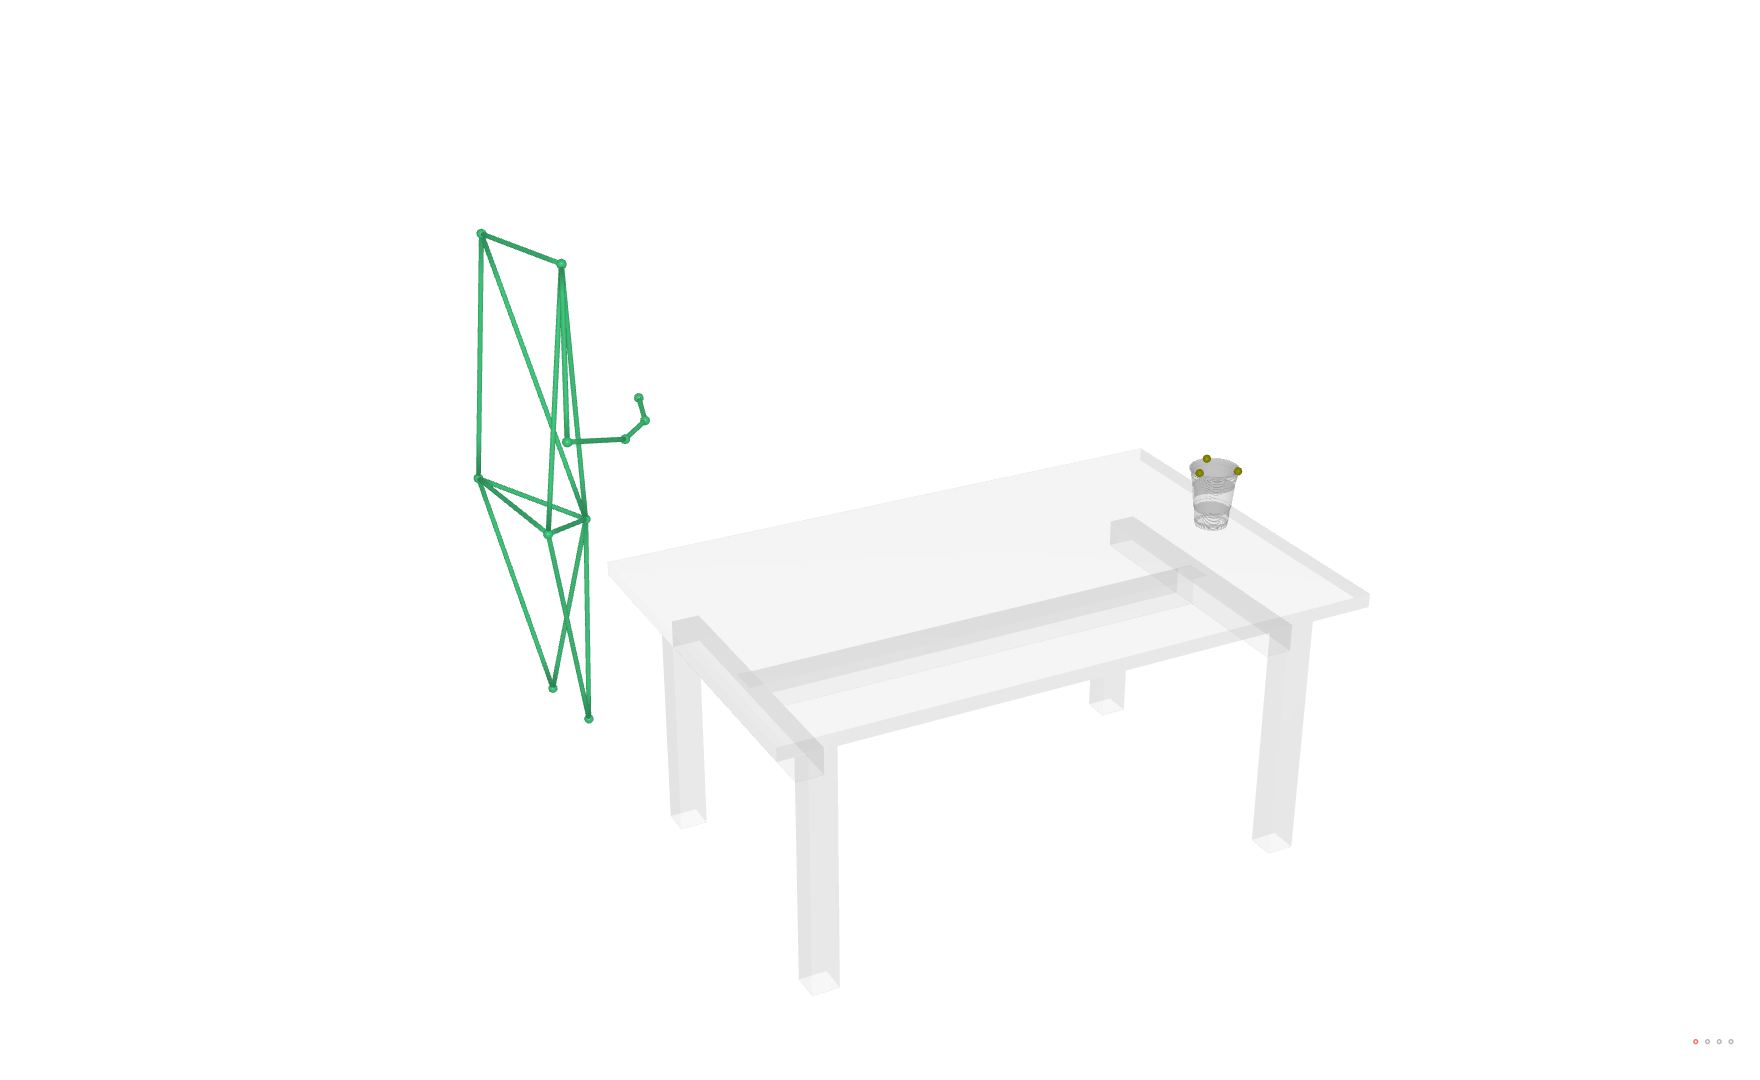

In [3]:
display.Image(SHOWCASE_PATH.joinpath("showcase.gif"))

In [4]:
class Recording(pd.Series):
    def __init__(self, path):
        trials = []
        for trial, segment in self.read_datafile(path).groupby("Trial"):
            segment["Time"] -= segment["Time"].min()
            trials.append(Trial(segment))

        pd.Series.__init__(self, data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")

    def read_datafile(self, path):
        events = pd.read_csv(
            path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "EventType", "Frame", "Time"), 
            skiprows = METADATA_LINES, 
            on_bad_lines = "skip"
        )

        recorded_data = pd.read_csv(
            path, 
            sep = "\t", 
            header = METADATA_LINES + len(events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        )[["Time"] + [f"{marker} {axis}" for axis in ["X", "Y", "Z"] for marker in SELECTED_MARKERS]]

        recorded_data = recorded_data.set_index("Time")
        recorded_data.columns = recorded_data.columns.str.split(" ", expand = True)
        recorded_data = recorded_data.stack(0, dropna = False)
        recorded_data.index = recorded_data.index.rename(["Time", "Marker"])
        recorded_data = recorded_data.reset_index()

        recorded_data["TrialTag"] = recorded_data["Time"].isin(events[events["EventType"] == "Trial"]["Time"])
        recorded_data["Trial"] = (recorded_data["TrialTag"].astype(int).diff() > 0).cumsum()
        recorded_data = recorded_data[recorded_data["Trial"] > 0]

        return recorded_data

    def __repr__(self):
        return f"[Recording ({len(self)} trials)]"

class Trial(pd.Series):
    def __init__(self, data, *args, **kwargs):
        pd.Series.__init__(self, {marker: self.process_marker_data(data) for marker, data in tuple(data.groupby("Marker", as_index = False))}, *args, **kwargs)
        self.enhance()
        self.determine_outcome()

    def process_marker_data(self, marker_data):
        data = marker_data[["Time", "X", "Y", "Z"]]
        data = data.set_index("Time")
        data = data.interpolate(limit_direction = "both")
        data = (data / SPATIAL_SCALE) * 100 # rescale from mm/s to cm
        return data.reset_index()

    def calculate_speed(self, subset):
        delta_pos = (subset[["X", "Y", "Z"]].shift(1).values - subset[["X", "Y", "Z"]].values) * SAMPLE_RATE
        speed = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
        speed = pd.Series(speed).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average
        speed /= 100 # rescale from cm/s to m/s
        return speed

    def calculate_acceleration(self, subset):
        return (subset["Speed"].diff() / SAMPLE_RATE).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average

    def sync_and_trim(self, subset, reference_timepoint, pre = None, post = None):
        if pre and post:
            subset = subset[(subset["Time"] > reference_timepoint - pre) & (subset["Time"] < reference_timepoint + post)].copy()
        subset["Time"] -= subset["Time"].min()
        subset.index -= subset.index.min()
        return subset

    def recenter_to_cup(self, subset, cup_centroid):
        subset[["X", "Y", "Z"]] = subset[["X", "Y", "Z"]].subtract(cup_centroid)
        return subset

    def enhance(self):
        self.cup_centroid = self["CupCentroid"].iloc[0][["X", "Y", "Z"]]
        # adding derived measures
        for marker in self.index:
            self.recenter_to_cup(self[marker], self.cup_centroid)
            self[marker]["Speed"] = self.calculate_speed(self[marker])
            self[marker]["Acceleration"] = self.calculate_acceleration(self[marker])

        # trimming to throw by using max ball speed (terminal velocity)
        reference_timepoint = self["Ball"]["Time"][self["Ball"]["Speed"].replace(np.nan, 0).idxmax()]
        for marker in self.index:
            self[marker] = self.sync_and_trim(
                self[marker], 
                reference_timepoint, 
                pre = 1, 
                post = DISPATCH_MARGIN
            )

        # trimming and "centering" around throw movement instead of terminal velocity
        reference_timepoint = self["Ball"]["Time"][self["Ball"]["Acceleration"].replace(np.nan, 0).idxmax()]
        for marker in self.index:
            self[marker] = self.sync_and_trim(
                self[marker], 
                reference_timepoint, 
                pre = DISPATCH_MARGIN, 
                post = 0.6
            )
    
    def ball_distance_to_cup_centroid(self):
        return pd.DataFrame(dict(
            Time = self["Ball"]["Time"], 
            Distance = np.sqrt(np.sum((self["Ball"][["X", "Y"]].values - self["CupCentroid"][["X", "Y"]].values)**2, axis = 1))
        ))
    
    def determine_outcome(self):
        self.outcome = ((self["Ball"]["Z"] <= 0) & (self["Ball"]["Z"] >= -1.5) & (self.ball_distance_to_cup_centroid()["Distance"] <= (CUP_RADIUS - BALL_RADIUS))).any()

    def __repr__(self):
        return f"[Trial] {'Hit' if self.outcome else 'Miss'}"

class Session(pd.DataFrame):
    def __init__(self, session_id, session_data):
        pd.DataFrame.__init__(self, session_data)
        self.session_id = session_id

    def __repr__(self):
        return f"[Session {self.session_id}]"

class Dataset(pd.Series):
    def __init__(self):
        sessions = []
        for session_path in Path(DATA_PATH).iterdir():
            if session_path.name.startswith("Session"):
                session_id = int(session_path.name[7:])
                recording_data = []
                for recording_path in session_path.iterdir():
                    if recording_path.suffix == ".tsv":
                        player_id = int(recording_path.name[6])
                        condition = recording_path.stem.split("_")[1]
                        print("[LOADING]", "Session", session_id, "Player", player_id, condition)
                        recording_data.append(dict(
                            Player = player_id,
                            Condition = condition,
                            Recording = Recording(recording_path)
                        ))
                sessions.append(Session(session_id, recording_data))

        pd.Series.__init__(self, sorted(sessions, key = lambda session: session.session_id), index = range(1, len(sessions) + 1))

    def __repr__(self):
        return f"""[Dataset ({len([session for session in self if len(session)])} sessions: {", ".join([str(session.session_id) for session in self if len(session)])})]"""

dataset = Dataset()
print(dataset)

[LOADING] Session 1 Player 1 Darkness
[LOADING] Session 1 Player 1 Daylight
[LOADING] Session 1 Player 2 Darkness
[LOADING] Session 1 Player 2 Daylight
[LOADING] Session 5 Player 1 Darkness
[LOADING] Session 5 Player 1 Daylight
[LOADING] Session 5 Player 2 Darkness
[LOADING] Session 5 Player 2 Daylight
[Dataset (2 sessions: 1, 5)]


In [5]:
data = dataset[5]

In [6]:
def annotate_metadata():
    plt.annotate(f"Session {data.session_id}", xy = (1, 0.01), xycoords = ("axes fraction", "figure fraction"), ha = "right", va = "bottom", alpha = 0.5)

def mark_dispatch():
    plt.axvline(DISPATCH_MARGIN, color = "black", linestyle = "--", linewidth = 1, alpha = 0.05, zorder = -1)

def decorate_xaxis_ticks():
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: int(val * 1000))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

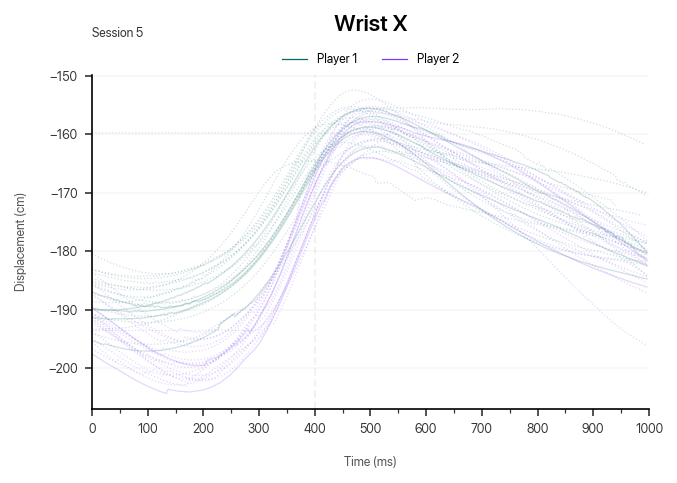

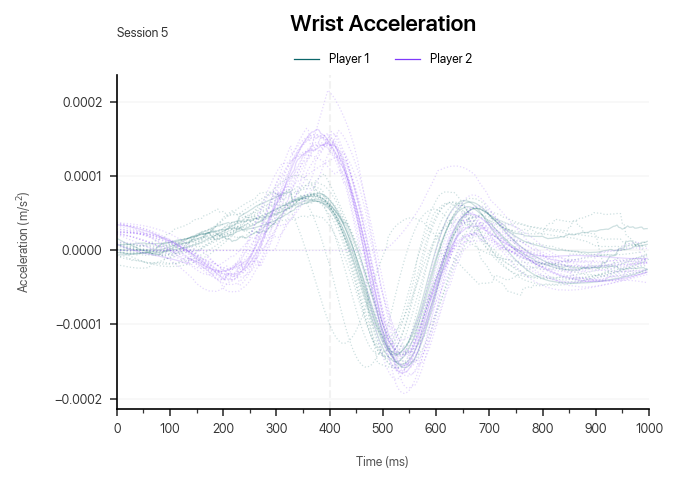

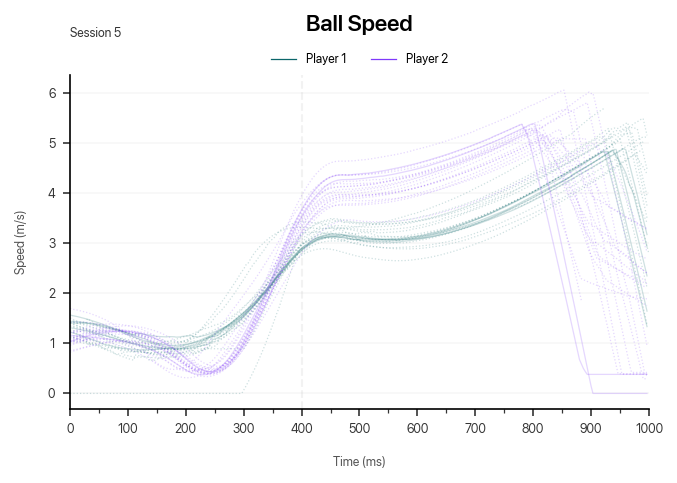

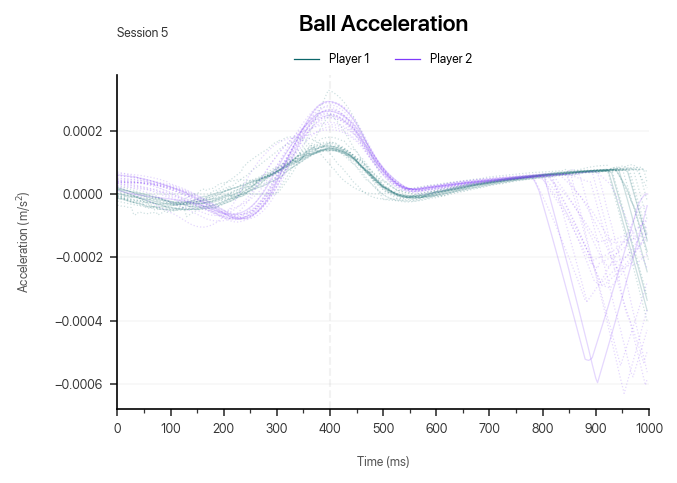

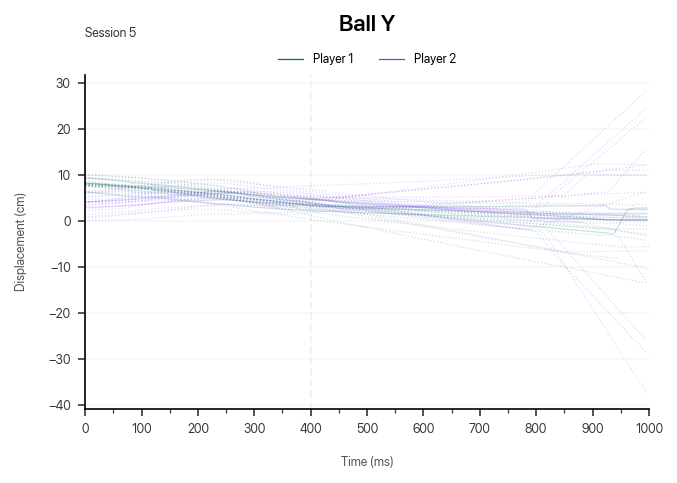

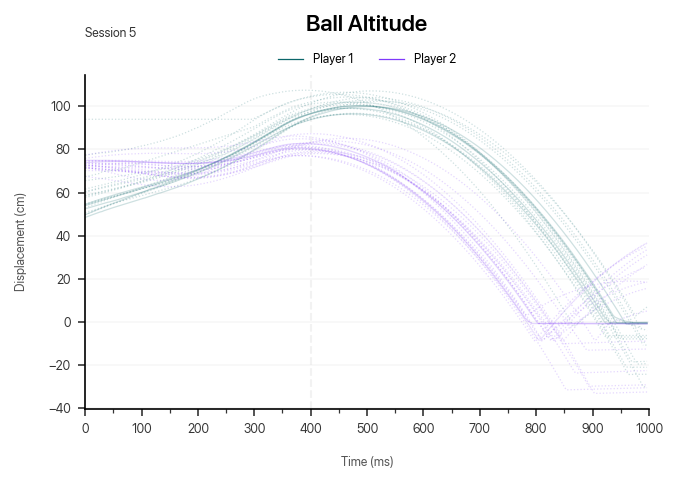

In [11]:
def plot_trajectory(marker, dimension):
    plt.figure()
    mark_dispatch()
    plt.annotate(
        f"Session {data.session_id}", 
        xy = (0, 0.95), 
        xycoords = ("axes fraction", "figure fraction"), 
        horizontalalignment = "left", 
        verticalalignment = "top", 
        alpha = 0.8, 
        in_layout = False
    )
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():
            plt.plot(
                subset[marker]["Time"],
                subset[marker][dimension], 
                color = "C0" if player == 1 else "C2",
                linewidth = 0.6, 
                linestyle = "-" if subset.outcome else ":",
                alpha = 0.2
            )

    dimension = dimension if not dimension == "Z" else "Altitude"
    plt.title(f"{marker} {dimension}\n")
    plt.xlabel("Time (ms)")
    if dimension == "Speed":
        plt.ylabel(f"{dimension} (m/s)")
    elif dimension == "Acceleration":
        plt.ylabel(f"{dimension} (m/s$^2$)")
    else:
        plt.ylabel("Displacement (cm)")

    decorate_xaxis_ticks()
    plt.legend(
        handles = [lines.Line2D([0], [0], 
        color=color, 
        linewidth = 0.6) for color in ("C0", "C2")], 
        labels = ["Player 1", "Player 2"], 
        loc = "upper center", 
        bbox_to_anchor = (0.5, 1.1), 
        ncol = 2,
    )
    plt.margins(x = 0, y = 0.05)
    plt.tight_layout()
    # plt.savefig(SHOWCASE_PATH.joinpath(f"{marker}_{dimension}.png"), dpi = 300, bbox_inches = "tight")

plot_trajectory(marker = "Wrist", dimension = "X")
plot_trajectory(marker = "Wrist", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Speed")
plot_trajectory(marker = "Ball", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Y")
plot_trajectory(marker = "Ball", dimension = "Z")

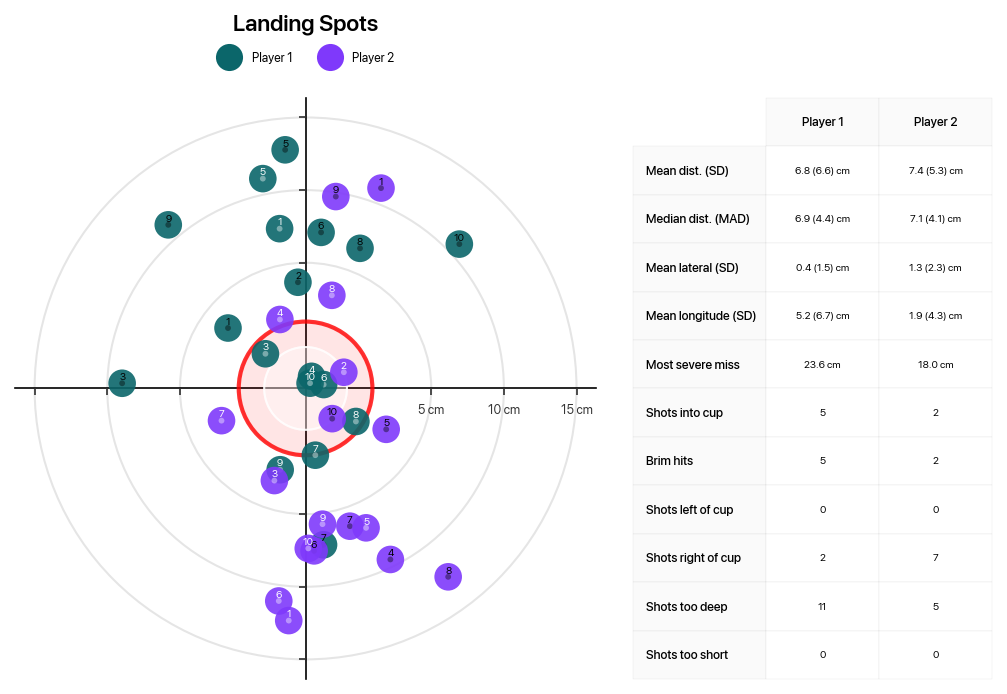

In [12]:
def plot_round_target():
    HIT_RADIUS = CUP_RADIUS - BALL_RADIUS # CALCULATED DISTANCES ARE TO THE BRIM OF THE CUP

    figure, axes = plt.subplots(figsize = (6.5, 4.5), ncols=2, width_ratios=[4.5, 2], gridspec_kw = dict(wspace = 0))
    disc_ax, summary_ax = axes

    disc_ax.spines["left"].set(zorder = -1)
    disc_ax.spines["bottom"].set(zorder = -1)
    disc_ax.spines["left"].set_position("center")
    disc_ax.spines["bottom"].set_position("center")
    # cup brim
    disc_ax.add_patch(patches.Circle((0, 0), 4.6, color="red", alpha = 0.1))
    disc_ax.add_patch(patches.Circle((0, 0), 4.6, color="red", alpha = 0.8, fill = False, linewidth = 2))
    # base of cup
    disc_ax.add_patch(patches.Circle((0, 0), 2.85, color="white", alpha = 0.4))
    disc_ax.add_patch(patches.Circle((0, 0), 2.85, color="white", alpha = 0.8, fill = False, linewidth = 1))
    # target disc levels
    for radius in (5, 10, 15):
        disc_ax.add_patch(patches.Circle((0, 0), radius + HIT_RADIUS, color="black", fill = False, alpha = 0.1))

    
    points = []
    for index, (player, condition, recording) in data.iterrows():
        for trial, trial_data in recording.items():
            ball_under_cup_plane = trial_data["Ball"][trial_data["Ball"]["Z"] <= CENTROID_OFFSET + 0.5].iloc[0] if trial_data["Ball"]["Z"].min() <= CENTROID_OFFSET + 0.5 else trial_data["Ball"].iloc[trial_data["Ball"]["Z"].idxmax()]

            touchdown_point = ball_under_cup_plane[["X", "Y"]] # point at which ball crosses transverse plane of cup
            points.append(dict(
                Player = player,
                Trial = trial,
                Condition = condition,
                Outcome = trial_data.outcome,
                Lateral = touchdown_point["Y"], # in the coordinate system of the recording, the Y-axis is lateral
                Longitude = touchdown_point["X"],
            ))

    zoom_range = 20
    landing_spots = pd.DataFrame(points)
    landing_spots["Distance"] = np.sqrt((landing_spots[["Lateral", "Longitude"]]**2).sum(axis = 1))

    for index, point in landing_spots[landing_spots["Distance"] <= zoom_range].iterrows():
        disc_ax.add_patch(plt.Circle(
            (point["Lateral"], point["Longitude"]),
            radius = BALL_RADIUS, 
            color = "C0" if point["Player"] == 1 else "C2",
            linewidth = 0,
            alpha = 0.9,
        ))
        disc_ax.add_patch(plt.Circle(
            (point["Lateral"], point["Longitude"]),
            radius = 0.2, 
            color = "white" if point["Condition"] == "Daylight" else "black",
            linewidth = 0,
            alpha = 0.4
        ))
        disc_ax.annotate(
            point["Trial"],
            (point["Lateral"], point["Longitude"]),
            fontsize = 5,
            textcoords = "offset points",
            color = "white" if point["Condition"] == "Daylight" else "black",
            horizontalalignment = "center",
            xytext=(0, 2), 
        )
    # disc_ax.plot(
    #     landing_spots["Lateral"],
    #     landing_spots["Longitude"],
    #     color = "grey",
    #     linestyle = ":",
    #     linewidth = 0.6,
    #     alpha = 0.4,
    # )

    disc_ax.set_title("Landing Spots\n\n")
    disc_ax.set_xlim((-zoom_range, zoom_range))
    disc_ax.set_ylim((-zoom_range, zoom_range))

    disc_ax.set_xticks(
        [-(HIT_RADIUS + val) for val in range(5, 20, 5)] + [HIT_RADIUS + val for val in range(5, 20, 5)], 
        3 * [""] + [str(val) + " cm" for val in range(5, 20, 5)]
    )
    disc_ax.set_yticks(
        [-(HIT_RADIUS + val) for val in range(5, 20, 5)] + [HIT_RADIUS + val for val in range(5, 20, 5)], 
        6 * [""]
    )
    disc_ax.grid(False)
    disc_ax.set_aspect("equal")

    landing_spots[["Distance", "Lateral", "Longitude"]] = landing_spots[["Distance", "Lateral", "Longitude"]].apply(lambda vals: vals - HIT_RADIUS, axis = 1).clip(lower = 0)
    measures = landing_spots.groupby("Player").agg(**{
        "Mean dist. (SD)": ("Distance", lambda vals: f"{vals.mean():.1f} ({vals.std():.1f}) cm"),
        "Median dist. (MAD)": ("Distance", lambda vals: f"{vals.median():.1f} ({np.median(np.absolute(vals - np.median(vals))):.1f}) cm"),
        "Mean lateral (SD)": ("Lateral", lambda vals: f"{vals.mean():.1f} ({vals.std():.1f}) cm"),
        "Mean longitude (SD)": ("Longitude", lambda vals: f"{vals.mean():.1f} ({vals.std():.1f}) cm"),
        "Most severe miss": ("Distance", lambda vals: f"{vals.max():.1f} cm"),
        "Shots into cup": ("Outcome", lambda vals: f"{vals.sum()}"),
        "Brim hits": ("Distance", lambda vals: f"{(vals <= BALL_RADIUS).sum()}"),
        "Shots left of cup": ("Lateral", lambda vals: f"{(vals < 0).sum()}"),
        "Shots right of cup": ("Lateral", lambda vals: f"{(vals > 0).sum()}"),
        "Shots too deep": ("Longitude", lambda vals: f"{(vals > 0).sum()}"),
        "Shots too short": ("Longitude", lambda vals: f"{(vals < 0).sum()}"),
    }).T

    disc_ax.legend(
        handles = [lines.Line2D([0], [0], marker = "o", color=color, markersize = 12, linewidth=0) for color in ("C0", "C2")], 
        labels = [f"Player {player_id}" for player_id in measures.columns], 
        loc = "upper center",
        bbox_to_anchor = (0.5, 1.1),
        ncol = 2,
    )

    table = summary_ax.table(
        measures.values,
        rowLabels = measures.index,
        rowColours = ["#fafafa"] * len(measures.index),
        colLabels = [f"Player {player_id}" for player_id in measures.columns],
        colLoc = "center",
        colColours = ["#fafafa"] * len(measures.columns),
        cellLoc = "center",
        loc = "center",
        bbox = (0.5, 0, 0.8, 1)
    )
    table.auto_set_font_size(False)
    table.set_fontsize(5)
    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(0.02)
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=dict(weight = 500))
    summary_ax.axis("off")

    plt.tight_layout()
    # plt.savefig(SHOWCASE_PATH.joinpath("landing_spot.png"), dpi = 300, bbox_inches = "tight")

plot_round_target()

In [9]:
def summary():
    result = []
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():

            after_passing_cup = subset["Ball"]["Z"] <= 0

            result.append({
                "Player": player, 
                "Condition": condition, 
                "Trial": trial, 
                "Outcome": "Hit" if subset.outcome else "Miss",
                "Ball Max Speed (m/s)": subset["Ball"]["Speed"].max(), 
                "Ball Max Altitude (cm)": subset["Ball"]["Z"].max(),
                "Ball Altitude at Cup Projection (cm)": subset["Ball"][after_passing_cup].iloc[0]["Z"] if after_passing_cup.any() else np.nan,
                "Wrist Max Speed (m/s)": subset["Wrist"]["Speed"].max(),
                "Distance to Cup at Dispatch (cm)": -subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["X"],
                "Deviation from Centerline at Dispatch (cm)": subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["Y"],
                "Elbow Altitude at Dispatch (cm)": subset["Elbow"]["Z"].loc[subset["Ball"]["Speed"].idxmax()],
            })

    return pd.DataFrame(result).set_index(["Player", "Condition", "Trial"]).round(2)

summary()

Outcome  Ball Max Speed (m/s)  Ball Max Altitude (cm)  \
Player Condition Trial                                                         
1      Darkness  1        Miss                  5.08                  104.39   
                 2        Miss                  5.23                  100.92   
                 3        Miss                  5.02                  102.99   
                 4        Miss                  5.20                  106.58   
                 5        Miss                  5.29                  105.65   
                 6        Miss                  5.70                  107.56   
                 7        Miss                  4.86                  107.22   
                 8        Miss                  5.31                  102.03   
                 9        Miss                  5.12                  104.19   
                 10       Miss                  5.13                  102.09   
       Daylight  1        Miss                  5.32                   99.15   
                 2        Miss                  5.49                   96.83   
                 3         Hit                  4.86                  100.39   
                 4         Hit                  4.83                   96.55   
                 5        Miss                  5.41                   96.31   
                 6         Hit                  4.89                   99.97   
                 7        Miss                  4.77                  102.44   
                 8         Hit                  4.83                   99.17   
                 9        Miss                  4.84                  101.93   
                 10        Hit                  4.87                  100.31   
2      Darkness  1        Miss                  5.81                   83.26   
                 2        Miss                  5.14                   79.89   
                 3        Miss                  6.02                   87.33   
                 4        Miss                  5.00                   85.21   
                 5        Miss                  5.09                   83.99   
                 6        Miss                  5.11                   82.49   
                 7        Miss                  5.15                   81.01   
                 8        Miss                  5.28                   81.95   
                 9        Miss                  6.06                   81.39   
                 10        Hit                  5.39                   82.78   
       Daylight  1        Miss                  5.38                   86.25   
                 2         Hit                  5.38                   80.70   
                 3        Miss                  5.30                   84.98   
                 4        Miss                  5.38                   80.12   
                 5        Miss                  5.28                   77.19   
                 6        Miss                  5.23                   80.21   
                 7        Miss                  5.27                   79.26   
                 8        Miss                  5.65                   78.61   
                 9        Miss                  5.19                   77.18   
                 10       Miss                  5.19                   78.11   

                        Ball Altitude at Cup Projection (cm)  \
Player Condition Trial                                         
1      Darkness  1                                     -0.24   
                 2                                     -0.31   
                 3                                     -0.42   
                 4                                     -1.39   
                 5                                     -0.34   
                 6                                     -1.08   
                 7                                     -0.66   
                 8                                     -1.20   
                 9    

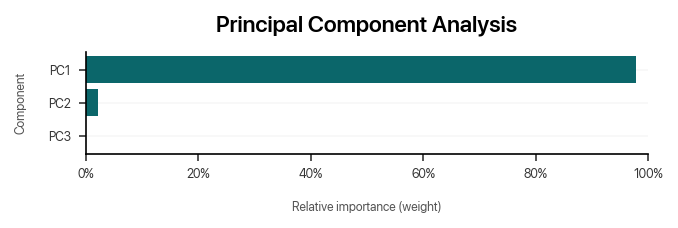

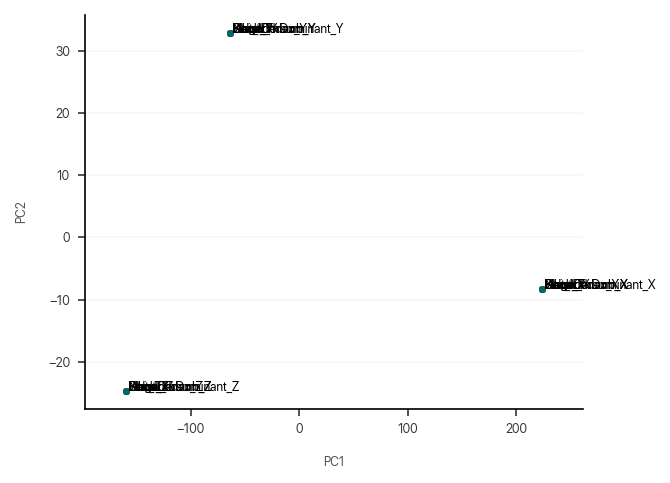

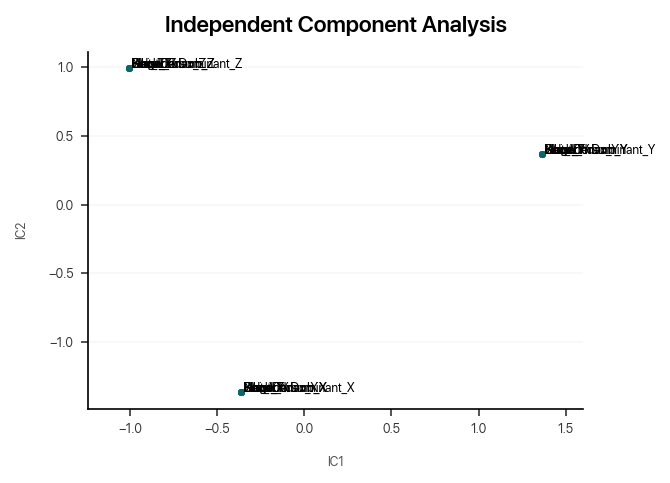

In [10]:
all_data = []
for trial, trial_data in data.loc[1]["Recording"].items():
    for marker, marker_data in trial_data.items():
        expanded_data = [marker_data[["X", "Y", "Z"]].add_prefix(marker + "_") for marker in SELECTED_MARKERS if marker not in ("Ball", "CupCentroid")]
        all_data.append(pd.concat(expanded_data, axis=1).dropna(axis = 1))

all_positional_data = pd.concat(all_data).sort_index()

scaled_data = preprocessing.scale(all_positional_data.T)

def principal_component_analysis():
    n_components = 3
    pca = decomposition.PCA(n_components)
    pca.fit(scaled_data)
    component_labels = ["PC" + str(i) for i in range(1, n_components + 1)]

    plt.figure(figsize=(4.5, 1.5))
    plt.title("Principal Component Analysis")
    plt.barh(component_labels[::-1], pca.explained_variance_ratio_[::-1])
    plt.xlim((0, 1))
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.xlabel("Relative importance (weight)")
    plt.ylabel("Component")
    plt.tight_layout()

    plt.figure()
    pca_data = pd.DataFrame(pca.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
    plt.scatter(pca_data["PC1"], pca_data["PC2"], s = 5)
    for marker, components in pca_data.iterrows():
        plt.annotate(" " + marker, (components["PC1"], components["PC2"]), fontsize = 6)
    plt.margins(x = 0.1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()

def independent_component_analysis():
    n_components = 2
    ica = decomposition.FastICA(n_components)
    ica.fit(scaled_data)
    component_labels = ["IC" + str(i) for i in range(1, n_components + 1)]

    plt.figure()
    plt.title("Independent Component Analysis")
    ica_data = pd.DataFrame(ica.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
    plt.scatter(ica_data["IC1"], ica_data["IC2"], s = 5)
    for marker, components in ica_data.iterrows():
        plt.annotate(" " + marker, (components["IC1"], components["IC2"]), fontsize = 6)
    plt.margins(x = 0.1)
    plt.xlabel("IC1")
    plt.ylabel("IC2")
    plt.tight_layout()

principal_component_analysis()
independent_component_analysis()